<a href="https://colab.research.google.com/github/rajivgaba/book-recommendation-chatbot/blob/main/book_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install kagglehub
# ! python3 -m pip install --upgrade pip
# ! pip install openai

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/books-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.58M/1.58M [00:00<00:00, 64.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/books-dataset/versions/1


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
import json

In [3]:
for file in os.listdir(path):
    print(file)

df = pd.read_csv(path + "/data.csv" )
df.head()

data.csv
intents.json


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [5]:
df['categories'].value_counts().head(20)

,count
categories,
Fiction,2588
Juvenile Fiction,538
Biography & Autobiography,401
History,264
Literary Criticism,166
Philosophy,160
Comics & Graphic Novels,159
Religion,137
Drama,132


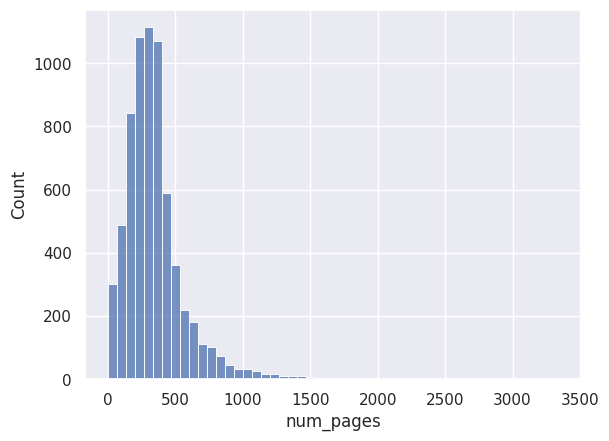

In [10]:
# print the num_pages and ratings_count on bar charts

plt.figure()
sns.set_theme(style="darkgrid")
sns.histplot(x=df['num_pages'], bins=50)
plt.show()

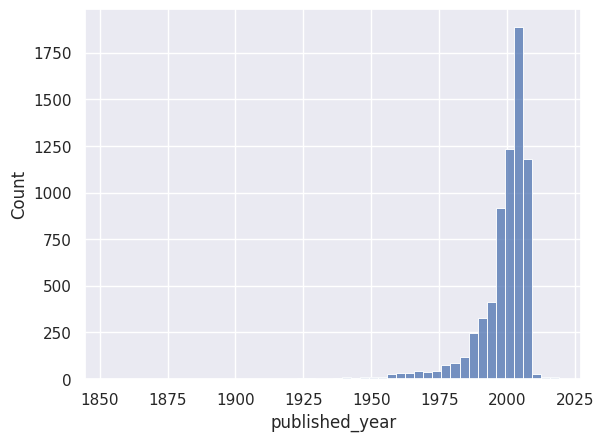

In [9]:
plt.figure()
sns.set_theme(style="darkgrid")
sns.histplot(x=df['published_year'], bins=50)
plt.show()

In [11]:
try:
    from google.colab import userdata
    pplx_key = userdata.get('PREPLEXITY_API_KEY')
    openai_key = userdata.get('OPENAI_KEY')
    print("keys imported from Google Colab userdata")
except:
    import dotenv
    from dotenv import load_dotenv
    import os
    load_dotenv()
    pplx_key = os.getenv('PREPLEXITY_API_KEY')
    openai_key = os.getenv('OPENAI_API_KEY')
    print("keys imported from local .env file")

keys imported from Google Colab userdata


In [32]:
def initialize_conversation():
  delimiter = "####"
  example_user_dict = {
      'categories' : 'history',
      'book size' : 'long',
      'author' : 'sidney sheldon',
      'title' : '_',
      'book age' : '_'
  }

  system_message = f"""
  You are an expert academician and an avid reader. Your task is to recommend books to the user.
  You need to get inputs from the user, understand their need to what kind of book they want to read. If the user is talking about something beyond book reading,
  you need to inform the user that you cannot assist with their request.
  For user inputs, you need to capture information in python dictionary. The dicitonary would look like this:
  {{
      'categories' : 'values',
      'book size' : 'values',
      'author' : 'values',
      'title' : 'values',
      'book age' : 'values'
  }}
  {delimiter} If the user ask is not related to book then you need to inform user that "I'm sorry, but I can only help with book recommendations."

  {delimiter}

  Here are some instructions around the values of these keys.
  - 'categories' and 'book size' are mandatory inputs and should be taken from user input.
  - 'book size' should strictly be 'small', 'medium' and 'large'
  - 'book age' should strictly be 'new', 'old' and 'very old'
  - 'categories' should be one of the genres like history, fiction, non-fiction, science, etc.
  - User may not have any preference for title or book age. In that case, you can fill the value as 'No Preference'.

  {delimiter}

  To fill the dictionary, you need to have following chain of thoughts:

  {delimiter}
  Thought 1: Ask a question to the user about what kind of book they want to read. Try and understand the genre \n
  or category of the book. Also, ask if they have any preference for any author or book title or how big the book should \n
  be or how old the book should be. Identify the keys for which you can fill the values confidently using the understanding \n

  {delimiter}
  Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step. \n
  Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to \n
  strengthen your understanding of the user's profile. If yes, move to the next Thought. If no, ask question on the keys \n
  whose values you are unsure of. It is a good practice to ask question with a sound logic as opposed to directly citing \n
  the key you want to understand value for.
  {delimiter}

  {delimiter}
  Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
  If you are not confident about any of the values, ask clarifying questions.
  {delimiter}

  Here is a sample conversation between the user and the assistant:
  User: "Hi, i am a student"
  Assistant: "Great. Being a student, you would really want to understand the world, life, nature, history. What kind of books \n
  would you like to read?"
  User: "I want to read a book about history"
  Assistant: "Thank you for the information. Are you interested in american history in particular?"
  User: "No. I read any history".
  Assistant: "Sure, do you have any preference for an author?"
  User: "Yes. Sindney Sheldon"
  Assistant: "{example_user_dict}"

  Start with a short welcome message and encourage the user to share their requirements.

  """

  conversation = [{"role" : "system", "content": system_message}]
  return conversation

In [13]:
initialize_conversation()

[{'role': 'system',
  'content': '\n  You are an expert academician and an avid reader. Your task is to recommend books to the user.\n  You need to get inputs from the user, understand their need to what kind of book they want to read and capture\n  information in python dictionary. The dicitonary would look like this:\n  {\n      \'categories\' : \'values\',\n      \'book size\' : \'values\',\n      \'author\' : \'values\',\n      \'title\' : \'values\',\n      \'book age\' : \'values\'\n  }\n  #### If the user ask is not related to book then you need to inform user that "I\'m sorry, but I can only help with book recommendations."\n\n  ####\n\n  Here are some instructions around the values of these keys.\n  - \'book size\' should strictly be \'small\', \'medium\' and \'large\'\n  - \'book age\' should strictly be \'new\', \'old\' and \'very old\'\n  - \'categories\' should be one of the genres like history, fiction, non-fiction, science, etc. \n  - User may not have any preference for

In [14]:
client = OpenAI(api_key = pplx_key, base_url="https://api.perplexity.ai")
model_name = "sonar-pro"

In [15]:
def get_chat_model_completions(input, json_format = False ):

  # model_name = "gpt-3.5-turbo"

  if json_format == True:
    system_mesage_json_output = """<<. Return the output in JSON format.>> """
    input[0]["content"] += system_mesage_json_output

    response = client.chat.completions.create(
        model = model_name,
        messages = input,
        temperature=0,
        max_tokens=500,
        # response_format = {"type" : "json_object"},
        seed = 1234
    )
    print(response.choices[0].message.content)
    output = json.loads(response.choices[0].message.content)
  else:
    response = client.chat.completions.create(
        model = model_name,
        messages = input,
        temperature=0,
        max_tokens=500,
        seed = 2345
    )
    output = response.choices[0].message.content


  return output

In [16]:
## Unit test

input_prompt = "what is a book"
x_input = [{"role" : "user", "content" : input_prompt}]
print(get_chat_model_completions(x_input))

A book is a structured work of recorded information—traditionally a set of pages bound together in covers—serving as both a physical object and an intellectual composition.[5][4]

- As a **physical object**: a book is “a set of written, printed, or blank sheets bound together between a front and back cover.”[5] Wikipedia similarly frames it as a presentation of recorded information through a medium, originally physical, later also electronic (e-books).[4]

- As an **intellectual work**: a book can mean a substantial written composition or a major division within a larger work (e.g., the “books” of the Bible).[5] Scholars describe the book as both an object and an idea: finite in form yet conceptually open, with its material and intellectual dimensions inseparable.[3]

- **Forms and types**:
  - Physical codex (hardcover, paperback), manuscripts, logbooks, directories.[4]
  - **E-books** are recognized as books in digital form.[5]
  - Content can be **fiction** (novels, novellas, short 

In [17]:
input_prompt = "what is a book"
y_input = [{"role" : "user", "content" : input_prompt}]
get_chat_model_completions(y_input, json_format = True)

{
  "query": "what is a book",
  "answer": "A book is a structured presentation of recorded information—typically verbal and/or graphical—contained in a medium; historically this meant printed pages bound together, and today it also includes electronic books (ebooks). [5]",
  "details": {
    "physical_definition": "In its traditional form, a book is a series of pages or sheets bound together within covers, with most modern pages made from uncoated paper stock. [1]",
    "common_components": [
      "cover",
      "title page",
      "copyright page",
      "table of contents",
      "introduction",
      "body",
      "conclusion",
      "back cover"
    ],
    "source_for_components": "[1]"
  },
  "notes": [
    "Modern usage encompasses both physical books and digital ebooks. [5]"
  ],
  "sources": {
    "primary_definition": "[5]",
    "physical_format_and_components": "[1]"
  }
}


{'query': 'what is a book',
 'answer': 'A book is a structured presentation of recorded information—typically verbal and/or graphical—contained in a medium; historically this meant printed pages bound together, and today it also includes electronic books (ebooks). [5]',
 'details': {'physical_definition': 'In its traditional form, a book is a series of pages or sheets bound together within covers, with most modern pages made from uncoated paper stock. [1]',
  'common_components': ['cover',
   'title page',
   'copyright page',
   'table of contents',
   'introduction',
   'body',
   'conclusion',
   'back cover'],
  'source_for_components': '[1]'},
 'notes': ['Modern usage encompasses both physical books and digital ebooks. [5]'],
 'sources': {'primary_definition': '[5]',
  'physical_format_and_components': '[1]'}}

In [18]:
def moderation_check(user_input):
  client = OpenAI(api_key=openai_key)
  response = client.moderations.create(input=user_input)
  # print(response)

  moderation_output = response.results[0].flagged

  if response.results[0].flagged == True:
    return "Flagged"
  else:
    return "Not Flagged"

In [19]:
# unit test

moderation_check(input_prompt)

'Not Flagged'

In [39]:
def intent_confirmation_layer(response_assistant):
    delimiter = "####"
    prompt = f""" You are a senior evaluator with an eye for detail. The input text will contain user input captured. \n
    You need to evaluate the input and confirm if all the keys are captured in the dictionary.
    The input text would be following keys:
    {{
    'categories' : '_',
    'book size' : '_',
    'author' : '_',
    'title' : '_',
    'book age' : '_'
    }}
    {delimiter}
    You give a response in JSON format. Only output a one-word string in JSON format at the key 'result' - Yes/No.
    {delimiter}

    Thought 1: Respond with a single word 'Yes' if all the keys are captured in the dictionary.  \n
    Thought 2: If any of the keys are not captured, respond with a single word 'NO' and then list the keys which are not captured in the dictionary. \n
    Thought 3: Respond "YES" only if all the keys are captured in the dictionary.
    Thought 4: Think carefully before answering.
    {delimiter}
    """
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": response_assistant}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0,
        seed=3456
    )
    # print(response.choices[0].message.content)
    output = json.loads(response.choices[0].message.content)
    return output


In [42]:
# unit test for intent confirmation layer
sample_response = """{
    "categories": "thriller",
    "book size": "short",
    "author": "sidney sheldon",
    "title": "no preference",
    "book age": "no preference"
}"""
intent_confirmation_layer(sample_response)['result']

'Yes'

In [50]:
sample_response_2 = """
{'categories': '', 'book size': 'No Preference', 'author': 'No Preference', 'title': 'No Preference', 'book age': 'No Preference'}
"""

intent_confirmation_layer(sample_response_2)['result']

'Yes'

In [43]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

In [44]:
iterate_llm_response(intent_confirmation_layer, sample_response, num=10)

Iteration: 0
{'result': 'Yes'}
--------------------------------------------------
Iteration: 1
{'result': 'Yes'}
--------------------------------------------------
Iteration: 2
{'result': 'Yes'}
--------------------------------------------------
Iteration: 3
{'result': 'Yes'}
--------------------------------------------------
Iteration: 4
{'result': 'Yes'}
--------------------------------------------------
Iteration: 5
{'result': 'Yes'}
--------------------------------------------------
Iteration: 6
{'result': 'Yes'}
--------------------------------------------------
Iteration: 7
{'result': 'Yes'}
--------------------------------------------------
Iteration: 8
{'result': 'Yes'}
--------------------------------------------------
Iteration: 9
{'result': 'Yes'}
--------------------------------------------------


In [25]:
def generate_recommendation(final_user_input):
    delimiter = "####"
    prompt = f"""You are an expert book recommender. You will be given a python dictionary
    with keys like 'categories', 'book size', 'author', 'title' and 'book age'.
    Your task is to generate a top 3 book recommendations based on the provided information. The corpus of books you can recommend is available in pandas dataframe {df}. \n

    Here are some instructions around the inputs you receive that you can use to generate the recommendation.
    - 'categories' refers to one of the genres like history, fiction, non-fiction,
    - 'book size' refers to the size of the book. which can be small, medium or large. 'small' implies less than 100 pages, 'medium' implies between 100 and 300 pages, and 'large' implies more than 300 pages.
    - 'author' refers to the author of the book.
    - 'title' refers to the title of the book.
    - 'book age' refers to the year of publication. If 'book age' is 'new', it means the book was published in the last 5 years, 'old' means it was published between 5 and 20 years ago, and 'very old' means it was published more than 20 years ago.

    Thought 1: Use the values in the dictionary to filter the dataframe and find books that match the user's preferences.
    Thought 2: If the user has no preference for a key, you can use the available keys and recommend books based on the other keys.
    Thought 3: In case of many matches , you can select the books with highest value of ratings_count and mention that in your response that these are popular books.
    Thought 4:
    {delimiter}
    The input dictionary is as follows:
    {final_user_input}
    {delimiter}
    Please provide your book recommendations in following format:
    \n\n
    Here are some recommendations for you to read: \n\n

    Recommendation 1: <book_title> by <author> <URL>
    Recommendation 2: <book_title> by <author> <URL>
    Recommendation 3: <book_title> by <author> <URL>
    """
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": final_user_input}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0,
        seed=4567
    )
    # print(response.choices[0].message.content)
    output = response.choices[0].message.content
    # output = json.loads(response.choices[0].message.content)
    return output

In [45]:
print(generate_recommendation(sample_response))

Here are some recommendations for you to read: 

Recommendation 1: The Doomsday Conspiracy by Sidney Sheldon http://books.google.com/books/content?id=3kYJAAAACAAJ&printsec=frontcover&img=1&zoom=1

Recommendation 2: The Best Laid Plans by Sidney Sheldon http://books.google.com/books/content?id=K7V9QgAACAAJ&printsec=frontcover&img=1&zoom=1

Recommendation 3: Are You Afraid of the Dark? by Sidney Sheldon http://books.google.com/books/content?id=p3w8PQAACAAJ&printsec=frontcover&img=1&zoom=1


In [47]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()
    print("Welcome to the Book Recommendation Chatbot!")
    print("I am here to help you find the perfect book based on your preferences.")
    print("At any point, if you want to exit, just type 'exit' or 'quit'.")

    # user_input = ''

    while True:
        user_input = input("")

        if user_input.lower() in ['exit', 'quit']:
            print("Thank you for using the Book Recommendation Chatbot. Goodbye!")
            break

        if moderation_check(user_input) == "Flagged":
            print("Assistant: Your input has been flagged for inappropriate content. Please try again with a new conversation.")
            break

        conversation.append({"role": "user", "content": user_input})
        response = get_chat_model_completions(conversation, json_format=False)
        print(response)

        if intent_confirmation_layer(response)['result'] == 'No':
            conversation.append({"role": "assistant", "content": json.dumps(response)})
            continue

        conversation.append({"role": "assistant", "content": json.dumps(response)})
        # print(f"Assistant: {json.dumps(response, indent=2)}")

        recommendation = generate_recommendation(json.dumps(response))
        print("*"*100)
        print(f"{recommendation}")
        print("*"*100)

        print(f"Thank you for using the Book Recommendation Chatbot! Have a nice day!!")
        break

In [48]:
dialogue_mgmt_system()

Welcome to the Book Recommendation Chatbot!
I am here to help you find the perfect book based on your preferences.
At any point, if you want to exit, just type 'exit' or 'quit'.
short history book
Welcome! I’d love to help you find a short history book that fits your taste. To tailor recommendations, could you tell me:

- What **category/genre of history** are you interested in (e.g., world history, a country or city like Paris, a theme like science or democracy, biographies, ancient/medieval/modern)?
- What **book size** do you prefer: **small**, **medium**, or **large**?
- Any preferred **author** or a specific **title** you have in mind?
- Do you care about the **book’s age**: **new**, **old**, **very old**, or No Preference?

Based on “short history book,” here are a few concise options across different angles, in case any spark interest:
- The Shortest History series (very compact overviews on topics like democracy, the world, etc.).[2]
- Paris: A Short History by Jeremy Black (cr